In [7]:
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path

In [8]:
def parse_benchmark_results(file_path: str, n_experiments: int = 5) -> np.ndarray:
    """
    Parse benchmark results from a file and return averaged metrics.
    
    Args:
        file_path: Path to the file containing benchmark results.
        n_experiments: Number of experiments to average over.
        
    Returns:
        numpy.ndarray: Array of averaged metrics in the following order:
            - initial_ram (MB)
            - data_load_time (s)
            - encoding_time (s)
            - scaling_time (s)
            - total_time (s)
            - final_ram (MB)
            
    Raises:
        FileNotFoundError: If the input file doesn't exist.
        ValueError: If the file format is incorrect or n_experiments is invalid.
    """
    # Validate inputs
    if n_experiments <= 0:
        raise ValueError("n_experiments must be a positive integer")
    
    file_path = Path(file_path)
    if not file_path.exists():
        raise FileNotFoundError(f"Input file not found: {file_path}")
    
    # Initialize accumulators
    metrics = {
        'initial_ram': 0.0,
        'data_load_time': 0.0,
        'encoding_time': 0.0,
        'scaling_time': 0.0,
        'total_time': 0.0,
        'final_ram': 0.0
    }
    
    try:
        with open(file_path, 'r') as f:
            for _ in range(n_experiments):
                # Read and parse each metric with error handling
                metrics['initial_ram'] += float(f.readline().split()[-1][:-1])
                metrics['data_load_time'] += float(f.readline().split()[-2])
                metrics['encoding_time'] += float(f.readline().split()[-2])
                metrics['scaling_time'] += float(f.readline().split()[-2])
                metrics['total_time'] += float(f.readline().split()[-2])
                metrics['final_ram'] += float(f.readline().split()[-1][:-1])
                
    except (IndexError, ValueError) as e:
        raise ValueError(f"Error parsing file {file_path}: invalid format") from e
    except Exception as e:
        raise RuntimeError(f"Unexpected error reading file {file_path}") from e
    
    # Convert to numpy array and calculate averages
    result = np.array([
        metrics['initial_ram'],
        metrics['data_load_time'],
        metrics['encoding_time'],
        metrics['scaling_time'],
        metrics['total_time'],
        metrics['final_ram']
    ]) / n_experiments
    
    return result

In [9]:
three = parse_benchmark_results('./three_node.txt')
three_opt = parse_benchmark_results('./three_node_opt.txt')
one = parse_benchmark_results('./one_node.txt')
one_opt = parse_benchmark_results('./one_node_opt.txt')

In [24]:
def plot_benchmark_results(one, one_opt, three, three_opt, figsize = (15, 10)) -> None:
    # Create figure and axes
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('Performance Benchmark Comparison', fontsize=14, y=1.02)
    
    CONFIGURATIONS = {
        'xticks': [0, 1, 2, 3],
        'xlabels': ['one node', 'one node opt', 'three nodes', 'three nodes opt'],
        'colors': ['#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e'],  # matplotlib default blue and orange
        'titles': ['Data load time', 'Encoding time', 'Scaling time', 'Total time'],
        'metrics_idx': [1, 2, 3, 4]  # Indices for data_load, encoding, scaling, total_time
    }

    # Plot each metric
    for idx, (i, j) in enumerate([(0, 0), (0, 1), (1, 0), (1, 1)]):
        ax = axes[i, j]
        metric_idx = CONFIGURATIONS['metrics_idx'][idx]
        
        # Extract data for current metric
        data = [
            one[metric_idx],
            one_opt[metric_idx],
            three[metric_idx],
            three_opt[metric_idx]
        ]
        
        # Create bar plot
        bars = ax.bar(
            CONFIGURATIONS['xticks'],
            data,
            color=CONFIGURATIONS['colors'],
            edgecolor='black',
            linewidth=0.7
        )
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width()/2.,
                height * 1.02,
                f'{height:.2f}',
                ha='center',
                va='bottom',
                fontsize=10
            )
        
        # Configure axes
        ax.set_xticks(CONFIGURATIONS['xticks'])
        ax.set_xticklabels(CONFIGURATIONS['xlabels'], rotation=45, ha='right')
        ax.set_title(CONFIGURATIONS['titles'][idx], pad=10)
        ax.set_ylabel('Seconds')
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_axisbelow(True)  # Grid behind bars
    
    # Adjust layout
    plt.tight_layout()
    return fig

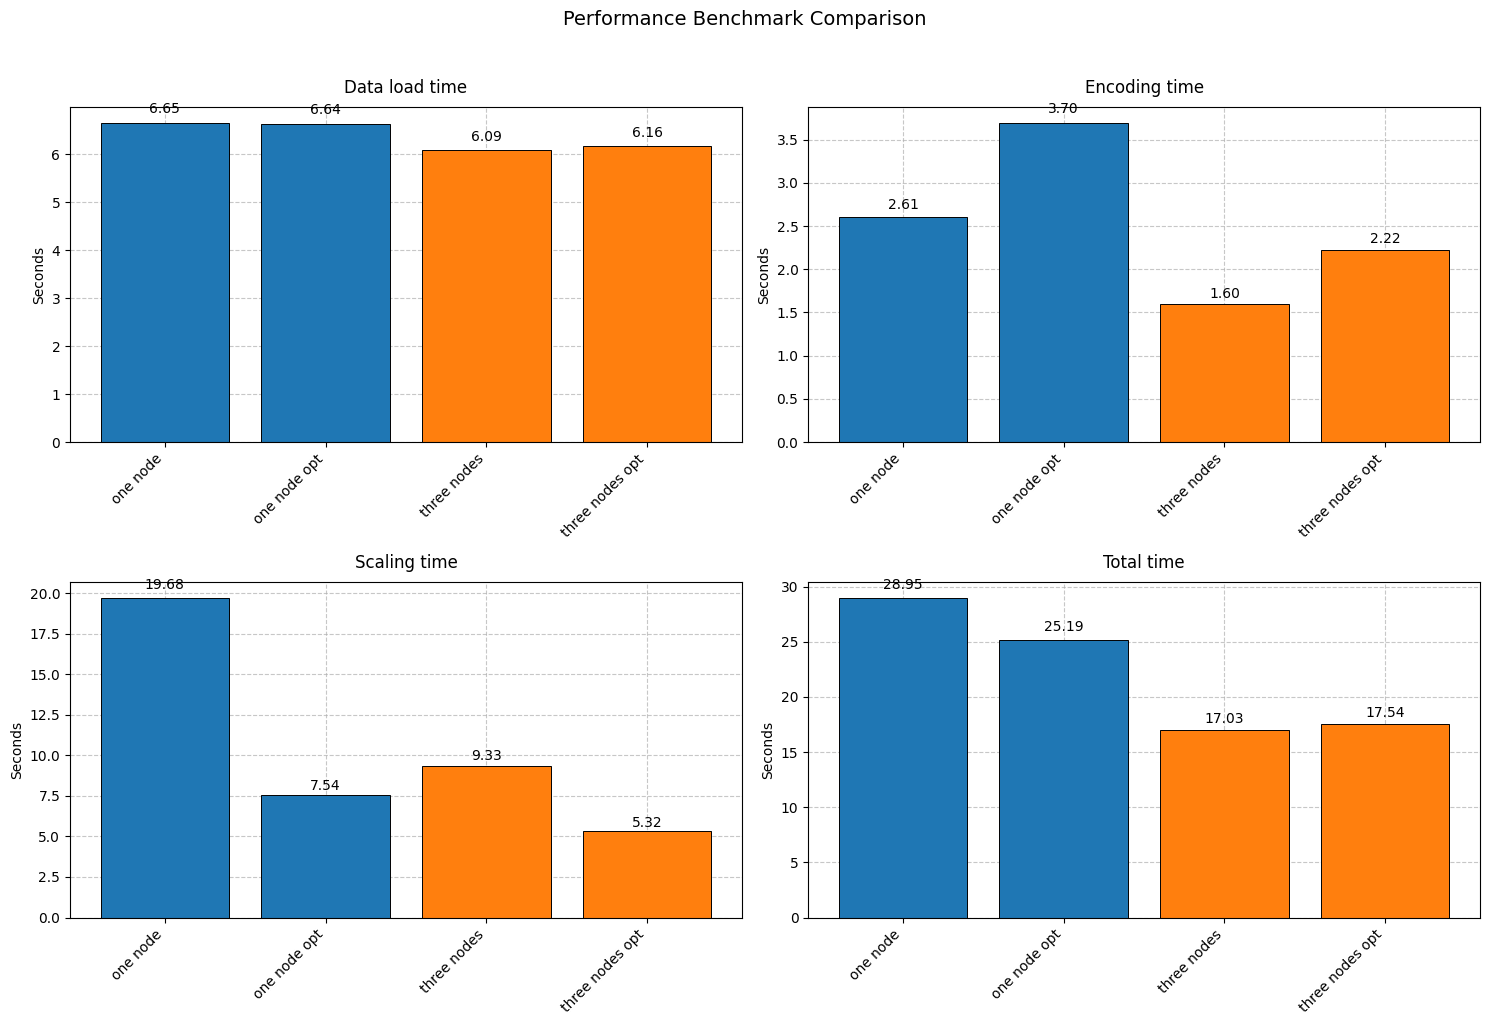

In [25]:
fig = plot_benchmark_results(one, one_opt, three, three_opt)
plt.show()

In [ ]:
def plot_ram_usage_comparison(one, one_opt, three, three_opt, figsize = (13, 5)) -> plt.Figure:
    # Configuration
    CONFIG = {
        'colors': {
            'one': '#1f77b4',        # matplotlib blue
            'one_opt': '#ff7f0e',    # matplotlib orange
            'three': '#d62728',      # matplotlib red
            'three_opt': '#2ca02c'   # matplotlib green
        },
        'labels': ['one node', 'one node opt', 'three nodes', 'three nodes opt'],
        'bar_width': 0.8
    }
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'wspace': 0.3})
    fig.suptitle('RAM Usage Analysis', fontsize=14, y=1.05)
    
    # Plot 1: Absolute RAM usage
    ax1 = axes[0]
    initial_ram = [one[0], one_opt[0], three[0], three_opt[0]]
    final_ram = [one[-1], one_opt[-1], three[-1], three_opt[-1]]
    
    # Position of bars
    x = np.arange(4) * 2
    ax1.bar(x - CONFIG['bar_width']/2, initial_ram, 
            width=CONFIG['bar_width'], color=list(CONFIG['colors'].values()),
            label='Initial RAM', edgecolor='black')
    ax1.bar(x + CONFIG['bar_width']/2, final_ram, 
            width=CONFIG['bar_width'], color=list(CONFIG['colors'].values()),
            label='Final RAM', edgecolor='black', hatch='//')
    
    ax1.set_title('Absolute RAM Usage', pad=10)
    ax1.set_ylabel('Memory Usage (%)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(CONFIG['labels'], rotation=45, ha='right')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend(framealpha=1)
    
    # Add value labels
    for i, (init, final) in enumerate(zip(initial_ram, final_ram)):
        ax1.text(x[i] - CONFIG['bar_width']/2, init + 1, f'{init:.1f}%', 
                ha='center', va='bottom', fontsize=9)
        ax1.text(x[i] + CONFIG['bar_width']/2, final + 1, f'{final:.1f}%', 
                ha='center', va='bottom', fontsize=9)
    
    # Plot 2: RAM usage difference
    ax2 = axes[1]
    ram_diff = [final - init for init, final in zip(initial_ram, final_ram)]
    
    bars = ax2.bar(range(4), ram_diff, color=list(CONFIG['colors'].values()),
                   edgecolor='black')
    ax2.set_title('RAM Usage Difference\n(Final - Initial)', pad=10)
    ax2.set_ylabel('Memory Difference (%)')
    ax2.set_xticks(range(4))
    ax2.set_xticklabels(CONFIG['labels'], rotation=45, ha='right')
    ax2.grid(True, linestyle='--', alpha=0.6)
    
    # Add value labels with sign
    for bar in bars:
        height = bar.get_height()
        va = 'bottom' if height >= 0 else 'top'
        ax2.text(bar.get_x() + bar.get_width()/2., height, 
                f'{height:+.1f}%', ha='center', va=va, fontsize=10)
    
    # Add zero reference line for difference plot
    ax2.axhline(0, color='black', linewidth=0.8, linestyle='-')

    return fig

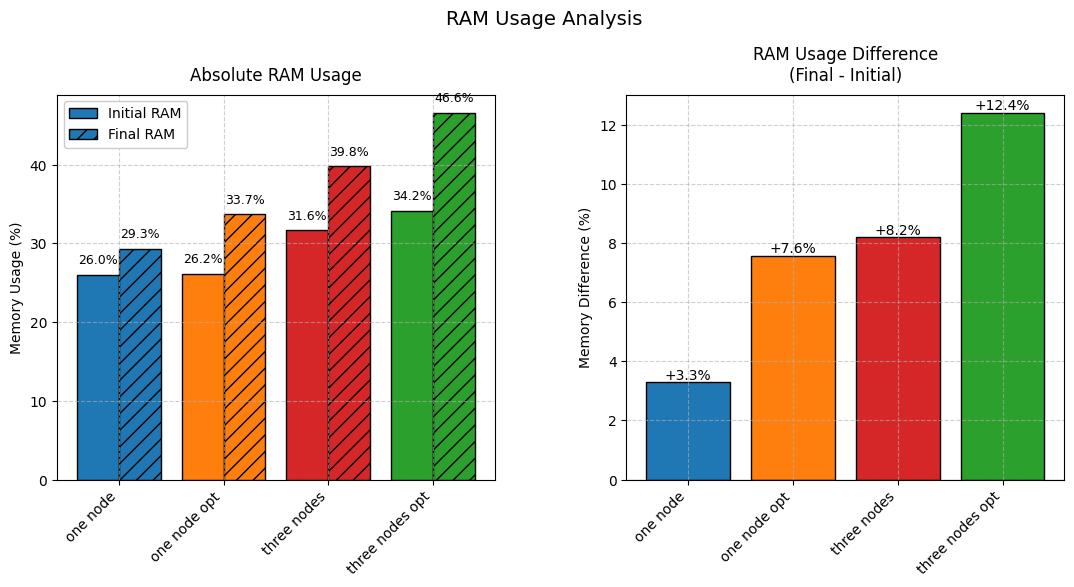

In [26]:
fig = plot_ram_usage_comparison(one, one_opt, three, three_opt)
plt.show()